In [ ]:
#Работу выполнили: Максаков Глеб, Кауш Александр

# 1. "Взять языка"

Я буду работать с показатели финансового состояния предприятий предоставленными вышкинским архивом http://sophist.hse.ru/hse/nindex.shtml 

Чтобы получить данные открываем вкладку "Финансы" -> "Показатели государственных финансов" -> "Месячные показатели (GOV_M)". Ссылка на таблицу http://sophist.hse.ru/hse/1/tables/GOV_M.htm

Я буду работать с рядом "Расходы консолидированного бюджета (CBEX_M) (млрд. руб)" (последний столбец). Чтобы быстро выкачать данный из таблицы использовал расширение для гугл хрома (https://chrome.google.com/webstore/detail/table-capture/iebpjdmgckacbodjpijphcplhebcmeop/related?hl=ru) 

Преобразовал в экселе время к формату: 01.01.1994, 01.02.1994 ... 01.03.2021

# 2. "Намалевич"

In [1]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


Populating the interactive namespace from numpy and matplotlib


In [2]:
debt = pd.read_csv('CBEX_M.csv', ';',index_col=['month'], parse_dates=['month'], dayfirst=True)

In [3]:
debt.head()

,CBEX_M
month,
1993-01-01,1.1
1993-02-01,1.4
1993-03-01,3.3
1993-04-01,2.3
1993-05-01,2.5


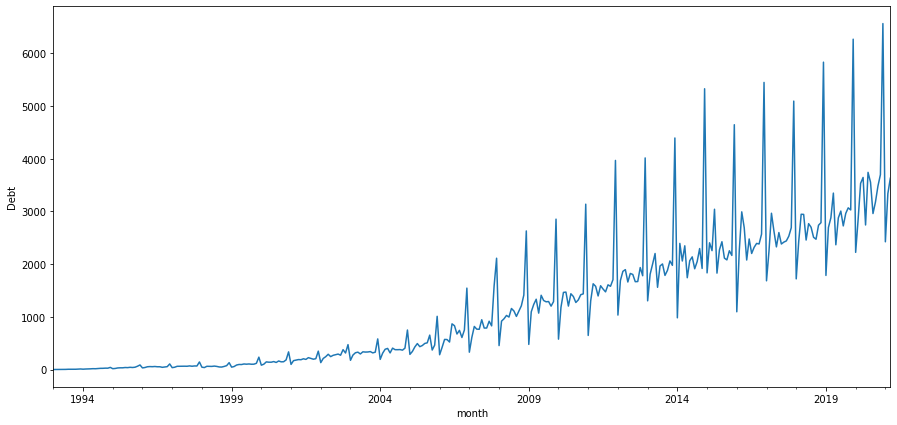

In [4]:
plt.figure(figsize(15,7))
debt.CBEX_M.plot()
plt.ylabel('Debt')
pylab.show()

Для визуализации графиков автокорреляции, тренда и сезонности я буду использовать библиотеку statsmodels

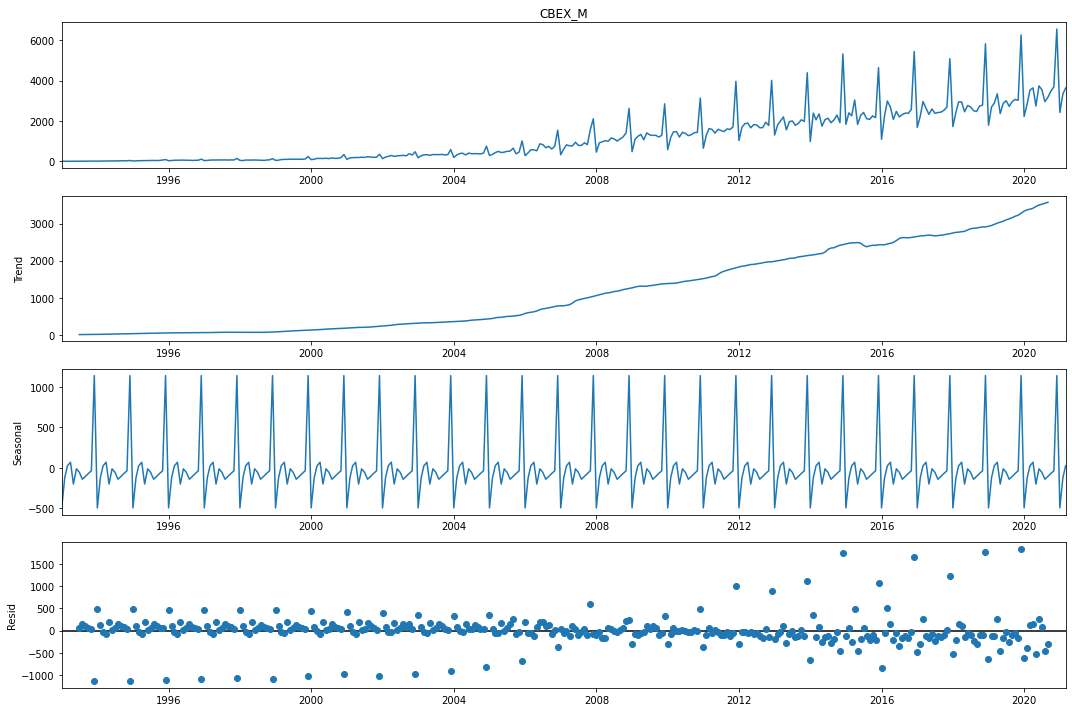

<Figure size 1080x720 with 0 Axes>

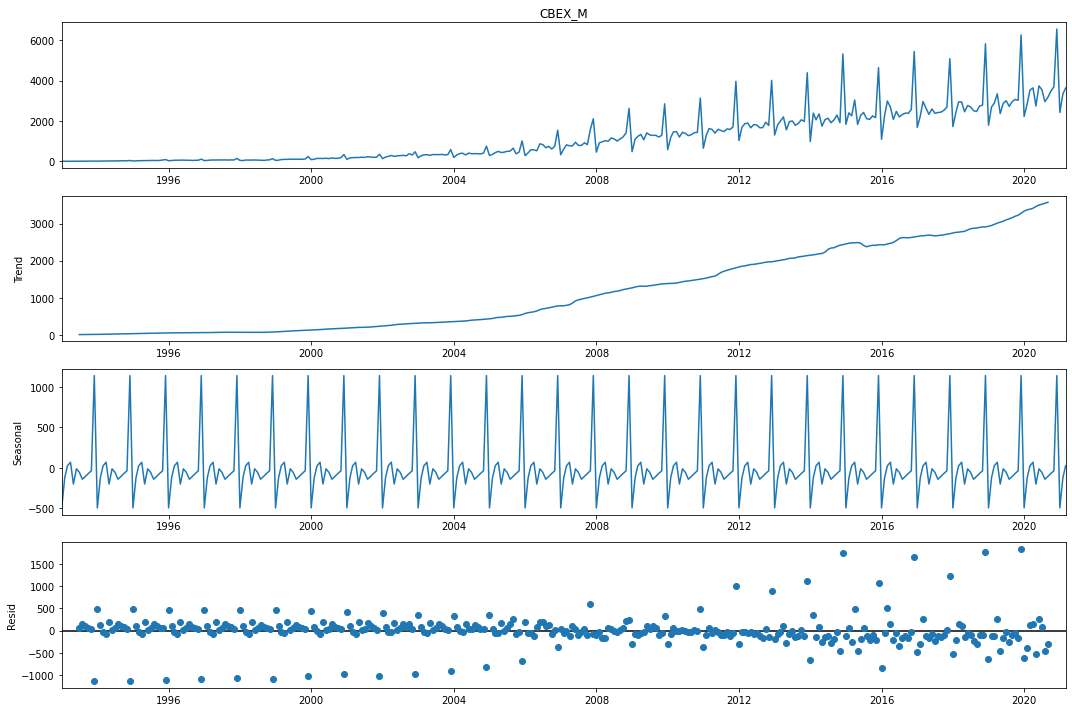

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(debt.CBEX_M).plot()

<Figure size 1080x360 with 0 Axes>

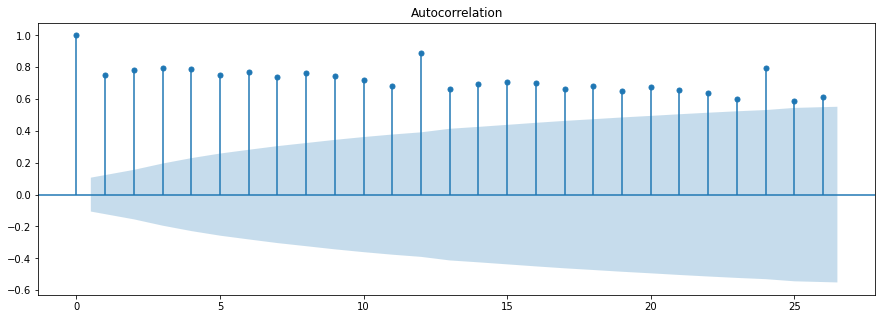

In [6]:
plt.figure(figsize(15,5))
sm.graphics.tsa.plot_acf(debt.CBEX_M.values)
pylab.show()

# 3. «Твиттер»

1. В данных виден возрастающий тренд. 
2. Присутствует сезонность (12 месячный период или годовая сезонность). Минимум всегда приходится на январь, а максимум на декабрь
3. Так как в данных присутствует и тренд и сезонность мы можем сразу сказать, что ряд не является стационарным.
4. Существенно изменивших тренд точек (точки излома) я не обнаружил.
4. Хорошо видно монотонно возрастающую дисперсию.

In [7]:
import numpy as np

In [8]:
debt['log_debt'] = np.log(debt.CBEX_M)

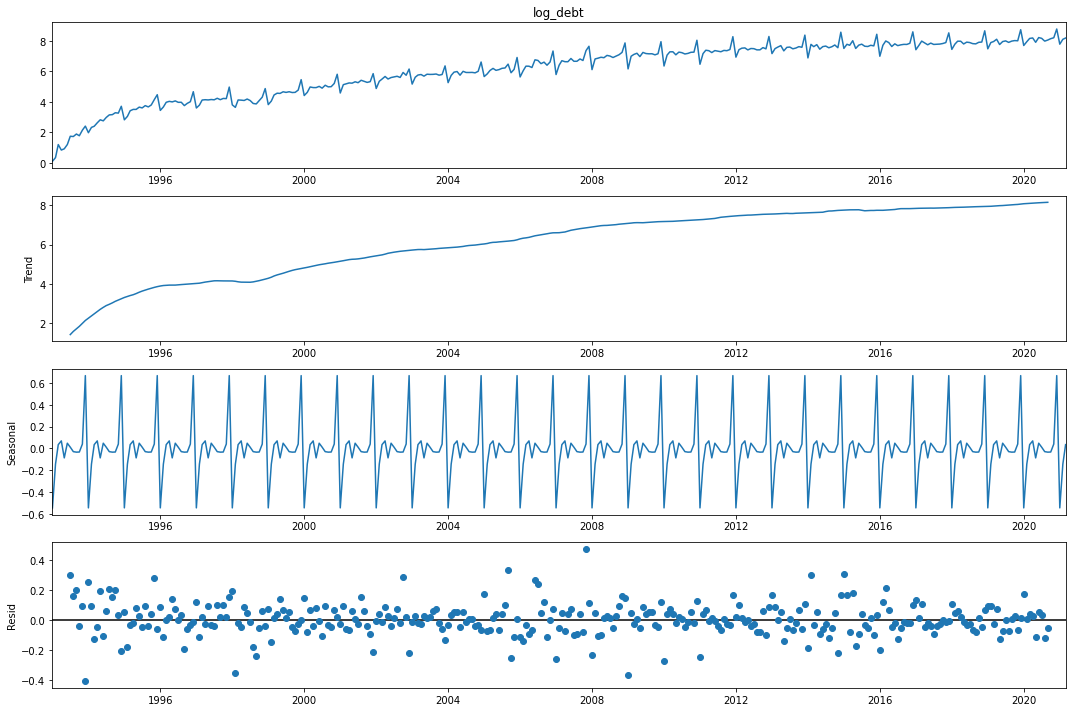

<Figure size 1080x720 with 0 Axes>

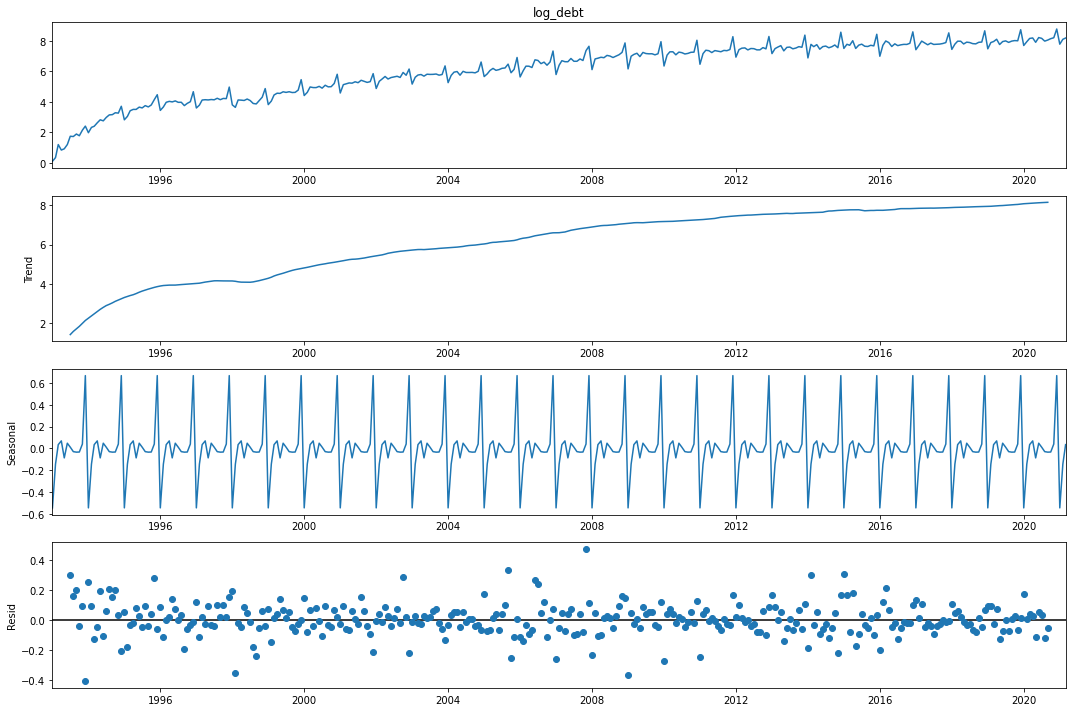

In [9]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(debt.log_debt).plot()

# 4. «Двенадцать месяцев»

## Наивные модели 1 и 2

In [10]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error

In [11]:
debt.index = pd.PeriodIndex(debt.index, freq="M")

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='log_debt'>)

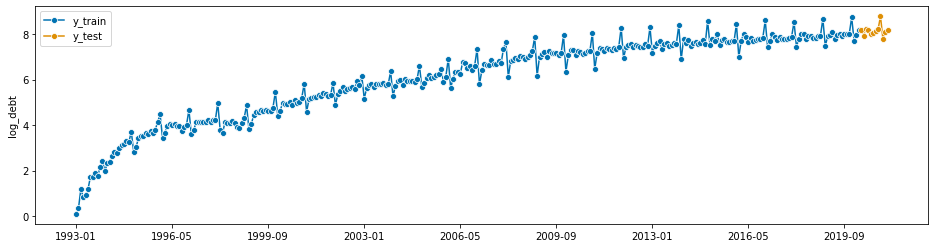

In [12]:
y_train, y_test = temporal_train_test_split(debt.log_debt, test_size=12)
plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [13]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [14]:
naive_forecaster_last = NaiveForecaster()
naive_forecaster_last.fit(y_train)
y_last = naive_forecaster_last.predict(fh)

naive_forecaster_seasonal = NaiveForecaster(sp=12)
naive_forecaster_seasonal.fit(y_train)
y_seasonal_last = naive_forecaster_seasonal.predict(fh=fh)

In [15]:
naive_last_mae = mean_absolute_error(y_last, y_test)
print(f"MAE for Naive y_t+1 = y_t is {naive_last_mae}")

MAE for Naive y_t+1 = y_t is 0.14760205438409998


In [16]:
naive_last_season_mae = mean_absolute_error(y_seasonal_last, y_test)
print(f"MAE for Naive season y_t+1 = y_t+1-12 is {naive_last_season_mae}")

MAE for Naive season y_t+1 = y_t+1-12 is 0.12158016031337993


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='log_debt'>)

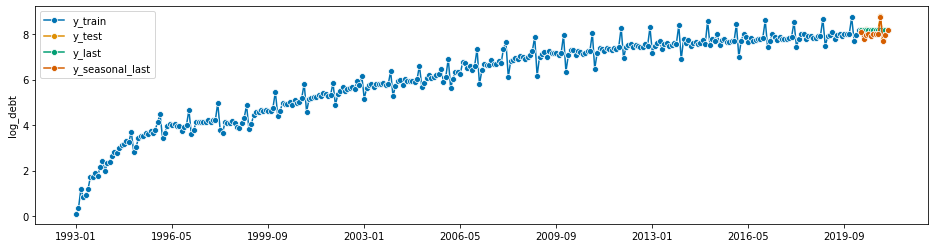

In [17]:
plot_series(y_train, y_test, y_last, y_seasonal_last, labels=["y_train", "y_test", "y_last", "y_seasonal_last"])

## SARIMA(1, 1, 1)(1, 0, 0)

In [18]:
from sktime.forecasting.arima import ARIMA

In [19]:
sarima = ARIMA(order=(1,1,1), seasonal_order=(1, 0, 0, 12))
sarima.fit(y_train)

/Users/timurzajnullin/Desktop/timeserials/venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))

In [20]:
sarima_predict = sarima.predict(fh)

In [21]:
sarima_mae = mean_absolute_error(sarima_predict, y_test)
print(f"MAE for SARIMA(1, 1, 1)(1, 0, 0) is {sarima_mae}")

MAE for SARIMA(1, 1, 1)(1, 0, 0) is 0.07205182920959945


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='log_debt'>)

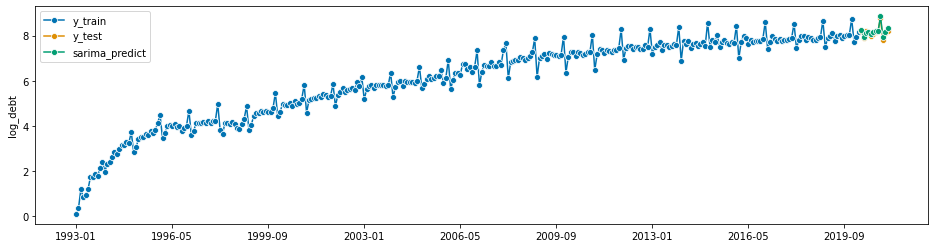

In [22]:
plot_series(y_train, y_test, sarima_predict, labels=["y_train", "y_test", "sarima_predict"])

## Алгоритм Хиндмана-Хандакара автоматического подбора SARIMA

In [23]:
from sktime.forecasting.arima import AutoARIMA

Начальные настройки по поиску лучшего набора решил взять с доки. https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.AutoARIMA.html

In [24]:
auto_sarima = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)
auto_sarima.fit(y_train)

AutoARIMA(d=0, max_p=2, max_q=2, sp=12, suppress_warnings=True)

In [25]:
auto_sarima_predict = auto_sarima.predict(fh)
auto_sarima_mae = mean_absolute_error(auto_sarima_predict, y_test)
print(f"MAE for AutoSARIMA is {auto_sarima_mae}")

MAE for AutoSARIMA is 0.04574139496807569


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='log_debt'>)

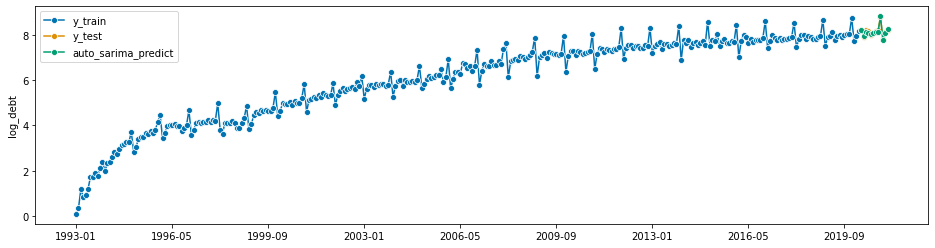

In [26]:
plot_series(y_train, y_test, auto_sarima_predict, labels=["y_train", "y_test", "auto_sarima_predict"])

## ETS(AAA)

In [27]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [28]:
ets = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12)
ets.fit(y_train)

ExponentialSmoothing(seasonal='multiplicative', sp=12, trend='add')

In [29]:
ets_predict = ets.predict(fh)
ets_mae = mean_absolute_error(ets_predict, y_test)
print(f"MAE for ETS(AAA) is {ets_mae}")

MAE for ETS(AAA) is 0.0706204646598303


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='log_debt'>)

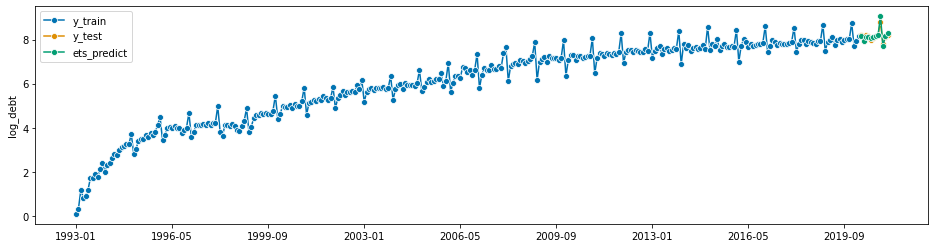

In [30]:
plot_series(y_train, y_test, ets_predict, labels=["y_train", "y_test", "ets_predict"])

## ETS с автоматическим выбором по AIC

In [31]:
from sktime.forecasting.ets import AutoETS

In [32]:
auto_ets = AutoETS(auto=True, n_jobs=-1, sp=12)
auto_ets.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [33]:
auto_ets_predict = auto_ets.predict(fh)
auto_ets_mae = mean_absolute_error(auto_ets_predict, y_test)
print(f"MAE for AutoETS is {auto_ets_mae}")

MAE for AutoETS is 0.05985903052651557


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='log_debt'>)

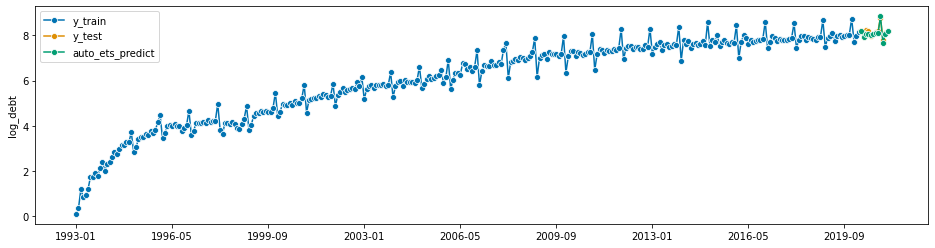

In [34]:
plot_series(y_train, y_test, auto_ets_predict, labels=["y_train", "y_test", "auto_ets_predict"])

# 5. «Кто на свете всех милее?»

По итогу исcледования меньше всего MAE у модели AutoARIMA (SARIMA). Выберу ее для предсказания по всей выборке

In [35]:
auto_sarima_best = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)
auto_sarima_best.fit(debt.log_debt)

AutoARIMA(d=0, max_p=2, max_q=2, sp=12, suppress_warnings=True)

Так как я работал с логарифмированным рядом, надо получить предсказание и провести обратно к обычному ряду. Для логарифма это экспонента.

In [36]:
log_predict = auto_sarima_best.predict(fh)

In [37]:
best_predict = np.exp(log_predict)

In [38]:
debt2 = debt[["CBEX_M"]]

In [39]:
debt2 = pd.concat([debt2, best_predict])

In [40]:
debt2.columns = ['CBEX_M', 'predict']

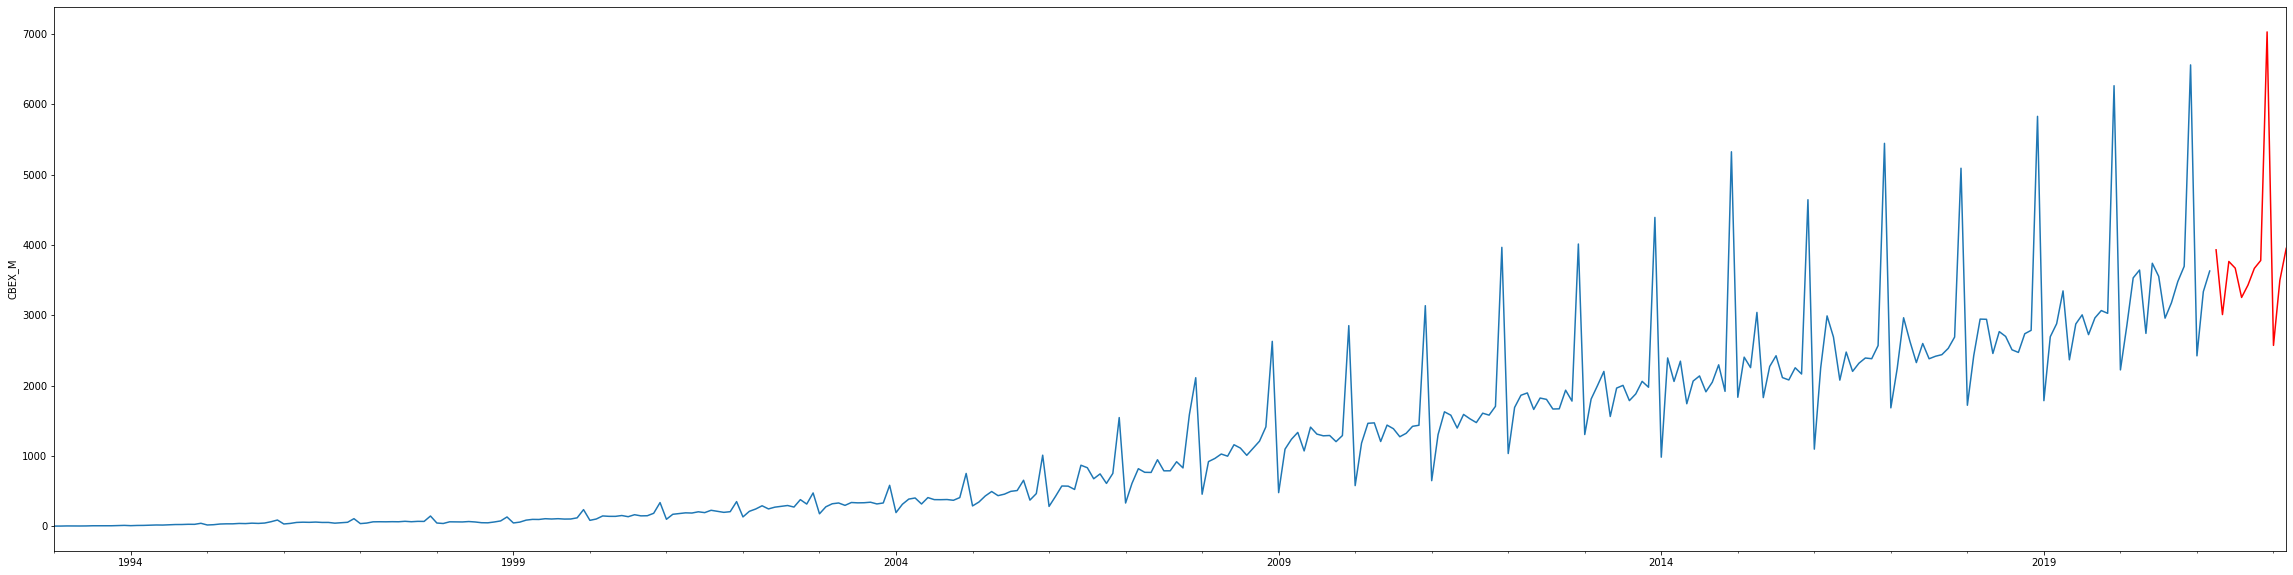

In [41]:
plt.figure(figsize(40,10))
debt2.CBEX_M.plot()
debt2.predict.plot(color='r')
plt.ylabel('CBEX_M')
pylab.show()

# 6. «Хождение в народ»

Я решил поработать с данными по индивидам.

# 7. «Кому на Руси жить хорошо?»

Поизучав вопросы я выделил для себя два интересных: 

M170 Скажите, пожалуйста, Вы счастливы? 

J6.1A Сколько в среднем часов и минут продолжается Ваш обычный рабочий день на этой работе? 
(часов)

Для выборки данных я сделал следующие операции:  

keep keep year idind M170 J6_1A  
drop if J6_1A > 24 #убрал не валидные часы работы (больше 24 никто не работает :) )   
drop if M170 > 5  #убрал записи, где люди не смогли ответить (валидные ответы с 1-5). Коды напишу ниже  
tostring M170, generate(y)  # для удобства перевел label в их числовые представления в предсказываю переменную y  
tostring J6_1A, generate(x)  
outsheet x y using data.csv , comma

Коды из кодификатора:
1 Очень счастливы  
2 Довольно счастливы  
3 Скорее счастливы, чем не счастливы  
4 Не очень счастливы  
5 Совсем несчастливы  

Получилась база с 25,604 записями

## Мой вопрос: Можно ли сказать, что количество часов в рабочем дне может нам что-то сказать о самочувствие человека?

In [42]:
data = pd.read_csv('data.csv')

In [43]:
data.head()

,year,idind,x,y
0,2012,5,9,4
1,2012,21443,15,4
2,2012,3,8,2
3,2012,25025,24,2
4,2012,25032,7,3


In [44]:
data.describe()

,year,idind,x,y
count,25604.000000,25604.000000,25604.000000,25604.000000
mean,2014.761756,30918.573270,9.496875,2.484299
std,2.226297,15537.480906,3.939385,0.875277
min,2012.000000,1.000000,0.000000,1.000000
25%,2012.000000,19060.750000,8.000000,2.000000
50%,2016.000000,33174.000000,8.000000,2.000000
75%,2017.000000,44115.250000,10.000000,3.000000
max,2017.000000,57087.000000,24.000000,5.000000


In [45]:
data[["x", "y"]].cov()

,x,y
x,15.518758,0.061194
y,0.061194,0.766109


<AxesSubplot:xlabel='x'>

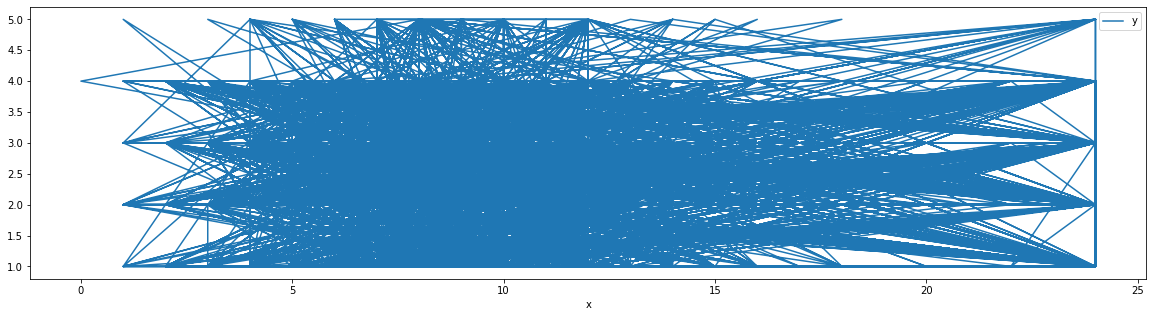

In [46]:
data.plot(x="x", y="y", figsize=(20, 5))

## Вывод по данным из таблицы и рисунку

Как мы видим из таблицы ковариация предикат и предсказываемая переменно имеют слабую линейную связь. 

График показывает, что большое скопление средних оценок (2-4) приходится на приходится на 5-12 часов. (что не удивительно, так как медиана и средннее количество рабочих часов это примерно 8-9ч)

# 9. «Три сестры»

In [47]:
from linearmodels import PooledOLS, PanelOLS, RandomEffects

In [48]:
panel_data = data.set_index(["year", "idind"])

In [49]:
panel_data.head()

x  y
year idind       
2012 5       9  4
     21443  15  4
     3       8  2
     25025  24  2
     25032   7  3

### сквозная (pool) модель

In [50]:
pool_m = PooledOLS(panel_data.y, panel_data.x)
print(pool_m.fit())

                          PooledOLS Estimation Summary                          
Dep. Variable:                      y   R-squared:                        0.7629
Estimator:                  PooledOLS   R-squared (Between):              0.9791
No. Observations:               25604   R-squared (Within):              -0.9786
Date:                Tue, Jun 15 2021   R-squared (Overall):              0.7629
Time:                        20:22:28   Log-likelihood                 -4.27e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   8.239e+04
Entities:                           3   P-value                           0.0000
Avg Obs:                       8534.7   Distribution:                 F(1,25603)
Min Obs:                       7843.0                                           
Max Obs:                       9893.0   F-statistic (robust):          8.239e+04
                            

### FE-модель

In [51]:
fe_m = PanelOLS(panel_data.y, panel_data.x, entity_effects=True)
print(fe_m.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:                      y   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):              0.0299
No. Observations:               25604   R-squared (Within):               0.0003
Date:                Tue, Jun 15 2021   R-squared (Overall):              0.0266
Time:                        20:22:28   Log-likelihood                -3.291e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.0467
Entities:                           3   P-value                           0.0046
Avg Obs:                       8534.7   Distribution:                 F(1,25600)
Min Obs:                       7843.0                                           
Max Obs:                       9893.0   F-statistic (robust):             8.0467
                            

### RE-модель

In [52]:
re_m = RandomEffects(panel_data.y, panel_data.x)
print(re_m.fit())

                        RandomEffects Estimation Summary                        
Dep. Variable:                      y   R-squared:                        0.7629
Estimator:              RandomEffects   R-squared (Between):              0.9791
No. Observations:               25604   R-squared (Within):              -0.9786
Date:                Tue, Jun 15 2021   R-squared (Overall):              0.7629
Time:                        20:22:29   Log-likelihood                 -4.27e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   8.239e+04
Entities:                           3   P-value                           0.0000
Avg Obs:                       8534.7   Distribution:                 F(1,25603)
Min Obs:                       7843.0                                           
Max Obs:                       9893.0   F-statistic (robust):          8.239e+04
                            

По параметру R^2 лучше показали себя сквозная и re-модель

# 10. «Ответ на главный вопрос»

Посмотрев на статистический анализ переменной x и результаты обучения модели, я могу ответить на свой вопрос так:  

Количество рабочих часов никак не влияет на самочувствие людей.